In [21]:
import os
import numpy as np

import torch
import torch.nn as nn
import librosa
import dataset
import easydict
import argparse
import network
import utils
import audio_utils
import torchaudio

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [78]:
opt = easydict.EasyDict({
    "data_dir": '/data1/singing_inpainting/dataset',
    "input_length": 220500,
    "image_height": 1025,
    "image_width": 431,
    "num_workers": 8,
    "batch_size": 1,
    "mask_type" : 'time',
    "load_folder" : '210731',
    "load_model_folder": '2',
    "gpu_ids": 1,
    "epoched": 7,
    "batch_sized": 4,
    "gan_type": 'WGAN',
    "in_channels" : 2,
    "out_channels" : 1,
    "latent_channels" : 32,
    "pad_type": 'zero',
    "activation": 'lrelu',
    "norm": 'in',
    "mask_init": 'lerp',
    "stage_num": 1,
    "save_interval": 7,
    "spec_pow":2,
    "phase":1,
    })

opt.load_dir = os.path.join('/data2/personal/jaejun/inpainting/results', opt.load_folder, opt.load_model_folder, 'models')
opt.model_name = 'deepfillv2_WGAN_epoch' + str(opt.epoched) + '_batchsize' + str(opt.batch_sized) + '.pth'
opt.result_dir = os.path.join('/data2/personal/jaejun/inpainting/results', opt.load_folder, opt.load_model_folder, 'validation_' + str(opt.epoched))
if opt.phase == 1:
    opt.in_channels = opt.in_channels + 1
    opt.out_channels = opt.out_channels + 1
def db_to_linear(db_input, opt):
    if opt.spec_pow == 2:
        linear_output = torchaudio.functional.DB_to_amplitude(db_input, ref=1.0, power=1)
    elif opt.spec_pow == 1:
        linear_output = torchaudio.functional.DB_to_amplitude(db_input, ref=1.0, power=0.5)
    return linear_output

In [79]:
if not os.path.exists(opt.result_dir):
    os.makedirs(opt.result_dir)
save_dir = os.path.join(opt.result_dir)

testset = dataset.InpaintDataset(opt, split='VALID')
print('The overall number of images equals to %d' % len(testset))

# Define the dataloader
dataloader = DataLoader(testset, batch_size = 1, pin_memory = True, num_workers=opt.num_workers)



The overall number of images equals to 738


In [80]:
model = network.GatedGenerator(opt)
model_dir = os.path.join(opt.load_dir, opt.model_name)
model.load_state_dict(torch.load(model_dir))
model.cuda()

L1Loss = nn.L1Loss()
relu = nn.ReLU()

# torch_gflim = torchaudio.transforms.GriffinLim(n_fft=2048, n_iter=60, win_length=2048, hop_length=512)
# torch_gflim.cuda()
custom_gflim = audio_utils.Custom_GriffinLim(n_fft=2048, n_iter=60, win_length=2048, hop_length=512)
custom_gflim.cuda()

Custom_GriffinLim()

In [229]:

first_MaskL1Losses = []
second_MaskL1Losses = []
only_mask_region_losses = []
psnrs = []
ssims = []
with torch.no_grad():
    for batch_idx, (audio, img, mask, mask_init) in enumerate(tqdm(dataloader)):
        scaler = 1
        img = img / scaler
        img = img[:,:,:opt.image_height-1,:opt.image_width-3]
        mask = mask[:,:,:opt.image_height-1,:opt.image_width-3]
        mask_init = mask_init[:,:,:opt.image_height-1,:opt.image_width-3]

        img = img.cuda()
        mask = mask.cuda()
        mask_init = mask_init.cuda()
        mask_sum = torch.sum(mask).detach().cpu()

        second_out = model(img, mask, mask_init)

        img = img * scaler
        # first_out = first_out * scaler
        second_out = second_out * scaler

        # first_out_wholeimg = img * (1 - mask) + first_out * mask        # in range [0, 1]
        second_out_wholeimg = img * (1 - mask) + second_out * mask
        # first_MaskL1Loss = L1Loss(first_out_wholeimg, img)
        second_MaskL1Loss = L1Loss(second_out_wholeimg, img)


        if mask_sum == 0:
            only_mask_region_loss = 0
        else:
            only_mask_region_loss = L1Loss(img*mask, second_out*mask) / mask_sum * 10250

        mask_idx = torch.where(mask[...,:]==1)[-1]
        psnr = utils.mask_psnr(second_out, img, mask_idx, pixel_max_cnt=100)
        ssim = utils.mask_ssim(second_out, img, mask_idx)

        # first_MaskL1Losses.append(first_MaskL1Loss.detach().cpu().numpy())
        second_MaskL1Losses.append(second_MaskL1Loss.detach().cpu().numpy())
        only_mask_region_losses.append(only_mask_region_loss.detach().cpu().numpy())
        psnrs.append(psnr)
        ssims.append(ssim)

        if batch_idx % opt.save_interval == 0:
            gt = db_to_linear(img[0,0,:,:] * scaler, opt)
            mask = mask[0,0,:,:]
            mask_init = db_to_linear(mask_init[0,0,:,:], opt) * mask
            masked_gt = gt * (1 - mask)
            masked_gt_lerp = gt * (1 - mask) + mask_init
            # first = db_to_linear(first_out[0,0,:,:] * scaler, ref=1.0, power=1)
            # firsted_img = gt * (1 - mask) + first * mask
            second = db_to_linear(second_out[0,0,:,:] * scaler, opt)
            seconded_img = gt * (1 - mask) + second * mask
            
        if opt.spec_pow == 2:
            dbpow = 'pow'
        elif opt.spec_pow == 1:
            dbpow = 'amp'
#         utils.save_samples(sample_folder = save_dir, sample_name = str(batch_idx), img_list = img_list, dbpow=dbpow)

        gt_pad = torch.nn.functional.pad(gt, (0, 3, 0, 1), mode='constant', value=0)
        mask_pad = torch.nn.functional.pad(mask, (0, 3, 0, 1), mode='constant', value=0)
        masked_gt_pad = torch.nn.functional.pad(masked_gt, (0, 3, 0, 1), mode='constant', value=0)
        masked_gt_lerp_pad = torch.nn.functional.pad(masked_gt_lerp, (0, 3, 0, 1), mode='constant', value=0)
        second_pad = torch.nn.functional.pad(second, (0, 3, 0, 1), mode='constant', value=0)
        seconded_img_pad = torch.nn.functional.pad(seconded_img, (0, 3, 0, 1), mode='constant', value=0)
        
        audio = audio.cuda()
        complex_spec = audio_utils.get_spectrogram(audio[0], power=None, return_complex=1, device='cuda')

        if opt.phase == 1:
            gt_mag = gt_pad ** (1 / opt.spec_pow)
            seconded_mag_img_pad = seconded_img_pad ** (1 / opt.spec_pow)
            gt_phase = torch.angle(complex_spec)
            second_phase = second_out[0,1,:,:]
            second_phase_pad = torch.nn.functional.pad(second_phase, (0, 3, 0, 1), mode='constant', value=0)
            seconded_img_pad_phase = gt_phase * (1 - mask_pad) + second_phase_pad * mask_pad
            
            seconded_img_real = seconded_mag_img_pad * torch.cos(seconded_img_pad_phase)
            seconded_img_imaginary = seconded_mag_img_pad * torch.sin(seconded_img_pad_phase)
            seconded_img_cat = torch.cat([seconded_img_real, seconded_img_imaginary], 0)
            seconded_img_cat = seconded_img_cat.permute(1, 2, 0).contiguous()
            seconded_img_cat_complex = torch.view_as_complex(seconded_img_cat)

            
        stop





  0%|          | 0/738 [00:01<?, ?it/s]


NameError: name 'stop' is not defined

In [240]:
seconded_img_cat.shape, seconded_img_cat_complex.shape

(torch.Size([1025, 431, 2]), torch.Size([1025, 431]))

In [ ]:
second_phase.shape, second_phase_pad.shape, seconded_gt_phase.shape, seconded_img_pad.shape

In [215]:
mag_spec = torch.abs(complex_spec)
phase_spec = torch.angle(complex_spec)
real_spec = mag_spec*torch.cos(phase_spec)
imaginary_spec = mag_spec*torch.sin(phase_spec)
cat_spec = torch.cat([real_spec,imaginary_spec],0)
cat_spec = cat_spec.permute(1, 2, 0).contiguous()
ccat_spec = torch.view_as_complex(cat_spec)
complex_spec.shape, mask.shape, mag_spec.shape, phase_spec.shape, cat_spec.shape, ccat_spec.shape

(torch.Size([1, 1025, 431]),
 torch.Size([1024, 428]),
 torch.Size([1, 1025, 431]),
 torch.Size([1, 1025, 431]),
 torch.Size([1025, 431, 2]),
 torch.Size([1025, 431]))

In [216]:
a = torch.istft(complex_spec, n_fft=2048, hop_length=512, win_length=2048)
b = torch.istft(ccat_spec, n_fft=2048, hop_length=512, win_length=2048)

In [217]:
ipd.Audio(a[0].detach().cpu(),rate=44100)

In [218]:
ipd.Audio(b.detach().cpu(),rate=44100)

In [245]:
mag_spec = gt_pad
gt_pad.shape

torch.Size([1025, 431])

In [242]:
seconded_img_pad_phase = gt_phase * (1 - mask_pad) + second_phase_pad * mask_pad
seconded_img_real = seconded_img_pad * torch.cos(seconded_img_pad_phase)
seconded_img_imaginary = seconded_img_pad * torch.sin(seconded_img_pad_phase)
seconded_img_cat = torch.cat([seconded_img_real, seconded_img_imaginary], 0)
seconded_img_cat = seconded_img_cat.permute(1, 2, 0).contiguous()
seconded_img_cat_complex = torch.view_as_complex(seconded_img_cat)
c = torch.istft(seconded_img_cat_complex, n_fft=2048, hop_length=512, win_length=2048)

In [243]:
ipd.Audio(c.detach().cpu(),rate=44100)

In [246]:
power_spec = torch.abs(complex_spec) ** 2


In [247]:
c = torch.istft(power_spec * complex_spec, n_fft=2048, hop_length=512, win_length=2048)

In [248]:
ipd.Audio(c.detach().cpu(),rate=44100)

In [285]:
complex_spec = audio_utils.get_spectrogram(audio[0], power=None, return_complex=1, device='cuda')
mag_spec = torch.abs(complex_spec)
phase_spec = torch.angle(complex_spec)
real_spec = mag_spec * torch.cos(phase_spec)
imaginary_spec = mag_spec * torch.sin(phase_spec)
cat_spec = torch.cat([real_spec, imaginary_spec], 0)
cat_spec2 = cat_spec.permute(1, 2, 0).contiguous()
cat_spec3 = torch.view_as_complex(cat_spec2)
wav = torch.istft(cat_spec3, n_fft=2048, hop_length=512, win_length=2048)

In [286]:
ipd.Audio(wav.detach().cpu(),rate=44100)

In [287]:
ipd.Audio(audio[0].detach().cpu(),rate=44100)

In [288]:
wav2 = torch.istft(complex_spec, n_fft=2048, hop_length=512, win_length=2048)
ipd.Audio(wav2.detach().cpu(),rate=44100)

In [304]:
a = 0.3
b = 5
epoch = 1
lr_g = 1e-4

In [309]:
lr = lr_g * (a ** (epoch // 5))
epoch += 1
print(lr)

3e-05


In [311]:
print(8e-05 < 3e-05)


False


In [280]:
imaginary_spec

tensor([[[ 0.0000e+00, -6.1856e-09, -1.2949e-08,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-2.7283e-08, -1.6457e-01,  8.3504e-02,  ..., -8.6632e-03,
           3.7616e-01,  7.7776e+00],
         [-4.6491e-09, -8.1574e-02, -2.6695e-03,  ..., -6.5420e-02,
           6.1169e-01, -7.9255e+00],
         ...,
         [-1.6307e-08,  7.2543e-05,  5.6136e-04,  ...,  1.1583e-03,
          -1.7540e-03,  3.4697e-03],
         [ 1.1739e-09, -4.2093e-04, -6.2188e-04,  ..., -6.2683e-04,
          -2.8932e-04, -3.5641e-03],
         [-1.2758e-10, -8.7885e-11,  0.0000e+00,  ..., -9.9640e-11,
          -7.4827e-12,  0.0000e+00]]], device='cuda:0')

In [ ]:
img_list = [gt, mask, mask_init, masked_gt_lerp, first, firsted_img, second, seconded_img]
show_spectrogram(save_dir, str(batch_idx), img_list, 1)

In [10]:
def save_samples(sample_folder, sample_name, img_list):
    # Save image one-by-one

    gt = img_list[0].numpy()
    mask = img_list[1].numpy()
    mask_init = img_list[2].numpy()
    masked_gt = img_list[3].numpy()
    first = img_list[4].cpu().numpy()
    firsted_img = img_list[5].numpy()
    second = img_list[6].numpy()
    seconded_img = img_list[7].numpy()

    fig, axes = plt.subplots(2, 4)
    plot_spectrogram(db_to_power_np(gt), axes[0, 0])
    plot_spectrogram(mask, axes[0, 1])
    plot_spectrogram(mask_init, axes[0, 2])
    plot_spectrogram(db_to_power_np(masked_gt), axes[0, 3])
    plot_spectrogram(db_to_power_np(first), axes[1, 0])
    plot_spectrogram(db_to_power_np(firsted_img), axes[1, 1])
    plot_spectrogram(db_to_power_np(second), axes[1, 2])
    plot_spectrogram(db_to_power_np(seconded_img), axes[1, 3])
    fig.set_size_inches(24, 12)
    fig.tight_layout()
    plt.show()
    
#     plt.savefig(os.path.join(sample_folder, sample_name + '_.png'))

In [11]:
def plot_spectrogram(spec, ax , title=None, ylabel='freq_bin', aspect='auto', xmax=None):
#   ax.set_title(title or 'Spectrogram (db)')
#   ax.set_ylabel(ylabel)
#   ax.set_xlabel('frame')

  im = ax.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
#   im = ax.imshow(spec, origin='lower', aspect=aspect, vmin=-400, vmax=400)
  if xmax:
    ax.set_xlim((0, xmax))
  return im

In [ ]:
second_out_wholeimg.device

In [ ]:
img.shape
second_pad = torch.nn.functional.pad(img, (0, 3, 0, 1), mode='constant', value=0)


In [ ]:
# utils.psnr(second_out_wholeimg, img)
utils.ssim(second_out_wholeimg, img)

In [ ]:
pow_to_db = torchaudio.transforms.AmplitudeToDB('power')

In [ ]:
plt.imshow(pow_to_db(db_to_power(seconded_img)).detach().cpu().numpy())

In [ ]:
first_out.shape

In [ ]:
test_masked_gt = gt * (1 - mask) + mask*255
plt.imshow(test_masked_gt)

In [64]:
def db_to_power(db, ref=1.0):
    return 10.0**(db/10.0 + torch.log10(torch.tensor(ref)))

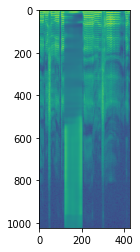

In [53]:
plt.imshow(seconded_img.detach().cpu().numpy())

In [60]:
a = []
a.append(second_MaskL1Loss.detach().cpu().numpy())

In [64]:
np.mean(psnrs)

17.783734775917836

In [66]:
gt.min(), gt.max()

(tensor(-100., device='cuda:0'), tensor(30.4782, device='cuda:0'))

In [76]:
db_second = db_to_power(second)

In [15]:
db_to_power(0)